## Atom Loading & Background Fluctuation Analysis
An investigation of how much the atom loading or the background fluctuates over time

In [13]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.ndimage  import gaussian_filter

import psycopg2 as pg
from configparser import ConfigParser

# for using datetime on x axis
import matplotlib.dates as mdates
import matplotlib.units as munits
munits.registry[dt.datetime] = mdates.ConciseDateConverter()

# for reading the database parameters from goodlogger's my_config.cfg
goodlogger_dir = "C:\\Users\\QC\OneDrive - UW-Madison\\Documents\\LabSoftware\\GOOD_logger"

cp = ConfigParser()
cp.read(os.path.join(goodlogger_dir,"my_config.cfg"))
conn_params = {'database':cp['DATABASE_SETUP']['Database'],
                'host':cp['DATABASE_SETUP']['Host'],
                'user':cp['DATABASE_SETUP']['User'],
                'password':cp['DATABASE_SETUP']['Password'],
                'port':cp['DATABASE_SETUP']['Port']}

results = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\"

sys.path.append("..\\")

from h5_data_utilities import * # helper functions for dealing with h5 files



### Useful functions

In [14]:
def get_data_in_time_interval(table, column_names, t_start, t_end):
    database = pg.connect(**conn_params)
    cur = database.cursor()

    t1 = t_start.timestamp()
    t2 = t_end.timestamp() 

    column_names = ['time'] + column_names

    cur.execute(f"SELECT {', '.join(column_names)} FROM {table} where time between {t1} and {t2}")
    row = cur.fetchone()
    rows = []
    while row is not None:
        rows.append([float(x) for x in row])
        row = cur.fetchone()
    return np.array(rows)

def get_data_most_recent(table, column_names, nrows):
    database = pg.connect(**conn_params)
    cur = database.cursor()

    column_names = ['time'] + column_names

    cur.execute(f"SELECT {', '.join(column_names)} FROM {table} ORDER BY time DESC LIMIT {nrows}")
    row = cur.fetchone()
    rows = []
    while row is not None:
        rows.append([float(x) for x in row])
        row = cur.fetchone()
    return np.array(rows)

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration
    
G_per_V_SM = 1e4*35e-6 # G per T * T per V for Stefan-Mayer FLC3-70

def atom_loading_hist():
    iterations = int(len(photocounts)/n_measurements)
    iterations, n_measurements
    
    first_shot_hists = np.array(
        [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                  for i in range(iterations)])
    
    second_shot_hists = np.array(
        [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                  for i in range(iterations)])
    
    cutoff1 = cutoff2 = single_atom_counts_per_s*t_SPCM_first_shot
    
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    
    cax=ax.imshow(first_shot_hists.transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot)
    ax.set_aspect('auto')
    cax2=ax2.imshow(second_shot_hists.transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot)
    ax2.set_aspect('auto')

def atom_loading_and_retention():

    iterations = int(len(photocounts)/n_measurements)
    iterations, n_measurements
    filter_sigma = 3
    
    mean1_by_iteration = [np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                                  for i in range(iterations)]
    mean2_by_iteration = [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                                  for i in range(iterations)]
    filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        
    filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
    
    # fig, ax2 = plt.subplots()
    # ax2.scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
    # ax2.plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)
    
    # ax2.scatter(range(iterations), retention_array, color='red', label='retention', s=1)
    
    # ax2.legend()
    # plt.show()

## 2025.01.05

In [72]:
fnames = get_files_by_criteria(date_filters=["2025-01-05"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["Cycler"], # only find files containing all these strings #ExperimentCycler
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 5 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-05\14\000021243-ExperimentCycler_single_photon.h5)
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-05\14\000021246-ExperimentCycler.h5)
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-05\15\000021249-ExperimentCycler.h5)
skipped 2 redundant files
0 scan_variables over 0 variable scans


C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-05\15\000021249-ExperimentCycler.h5
experiment: single_photon_experiment


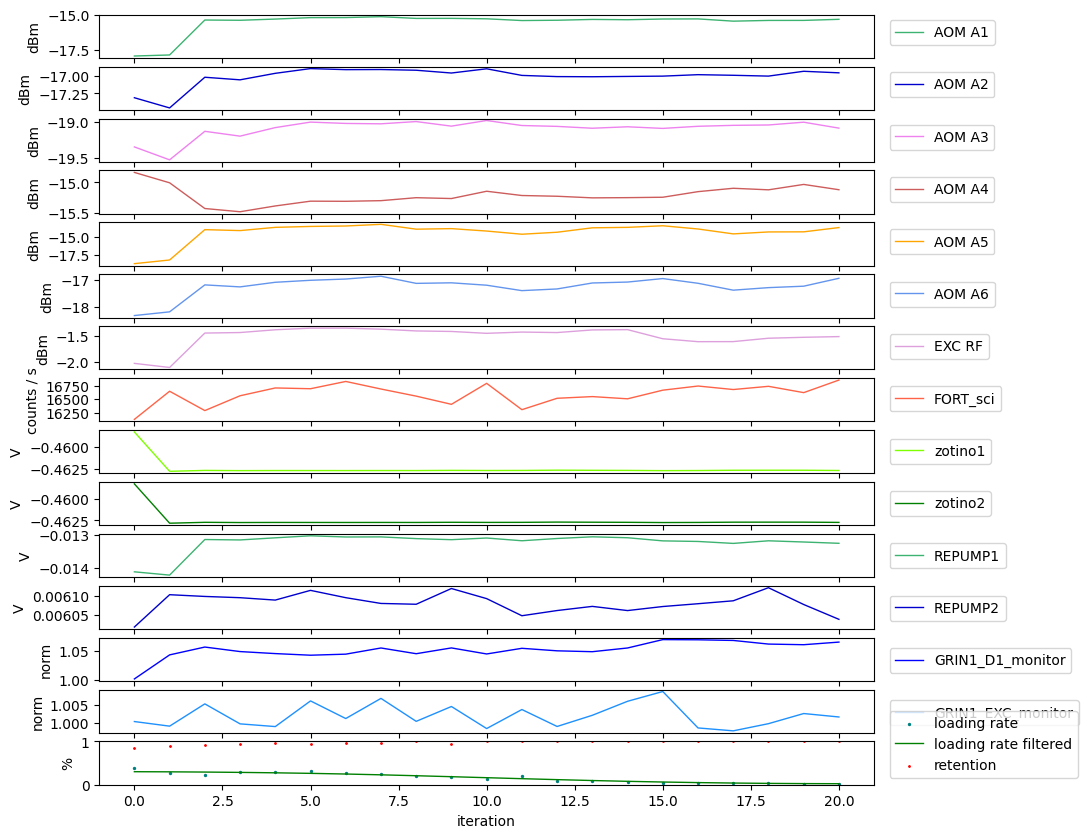

In [73]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""


i = 3 # At iteration ~10th: GVO with single photon exp started & Cycler resumed after GVO. 

f = h5py.File(fnames[i])
print(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()

print("experiment:",experiment_function)

cutoff1 = cutoff2 = 0.02*single_atom_counts_per_s



aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse', 'g', 'aquamarine', 'salmon', 'b','dodgerblue', 'crimson','darkgreen','orange','magenta','cyan','purple','royalblue','lime','cornflowerblue','pink']

plot_num = 0

iterations = int(len(photocounts)/n_measurements)
iterations, n_measurements


fig,axes = plt.subplots(nrows=15,sharex=True, figsize = (10,10))

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1
    
# GRIN1 EXC RF history
RF_history = locals()['p_excitation_history']
RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)
axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[plot_num], label='EXC RF', lw=1) # dBm
axes[plot_num].set_ylabel("dBm")

plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# # READOUT BACKGROUND: 2
# READOUT_1 = locals()['photocounts']
# READOUT_2 = locals()['photocounts2']
# READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
# READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
# axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
# axes[plot_num].set_ylabel("counts / s")
# plot_num += 1
# axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
# axes[plot_num].set_ylabel("counts / s")
# plot_num += 1


# Zotino output to shim coils

# Zotino : 1
zotino_sci_history = locals()['zotino_test1_monitor']
zotino_sci_mean_by_iteration = average_over_measurement(n_measurements, zotino_sci_history)
axes[plot_num].plot(zotino_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='zotino1', lw=1)
axes[plot_num].set_ylabel("V")
plot_num += 1
zotino_sci_history2 = locals()['zotino_test1_monitor']
zotino_sci_mean_by_iteration2 = average_over_measurement(n_measurements, zotino_sci_history2)
axes[plot_num].plot(zotino_sci_mean_by_iteration2[:], color=aom_colors[plot_num], label='zotino2', lw=1)
axes[plot_num].set_ylabel("V")
plot_num += 1


# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

# # PUMPING REPUMP: 2
# for i in range(2): # this time include the free space beams too
#     repump_power = locals()[f'PUMPING_REPUMP{i+1}_monitor']
#     repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

#     axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'PUMPING_REPUMP{i+1}', lw=1) # dBm
#     axes[plot_num].set_ylabel("V")
#     plot_num += 1

# GRIN: D1
FORT_sci_history = locals()['GRIN1_D1_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history/0.03)
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_D1_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1
# GRIN: EXC
FORT_sci_history = locals()['GRIN1_EXC_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/set_point_excitation
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_EXC_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1

# Atom loading and retention
filter_sigma = 3

mean1_by_iteration = [np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)]
mean2_by_iteration = [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)]
filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded
    
filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
axes[plot_num].scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
axes[plot_num].plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

axes[plot_num].scatter(range(iterations), retention_array, color='red', label='retention', s=1)
axes[plot_num].set_ylabel("%")
axes[plot_num].set_ylim(0,1)


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))


plt.show()

In [67]:
fnames = get_files_by_criteria(date_filters=["2025-01-04"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["Cycler"], # only find files containing all these strings #ExperimentCycler
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 10 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\18\000021196-ExperimentCycler.h5)
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\18\000021197-ExperimentCycler.h5)
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\18\000021199-ExperimentCycler.h5)
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\18\000021202-ExperimentCycler.h5)
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\18\000021203-ExperimentCycler_single_photon.h5)
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\19\000021215-ExperimentCycler.h5)
file 9 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\19\000021216-ExperimentCycler_microwave_Rabi.h5)
skipped 3 redundant files
0 scan_variables over 0 variable scans


C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\19\000021216-ExperimentCycler_microwave_Rabi.h5
experiment: microwave_Rabi_experiment


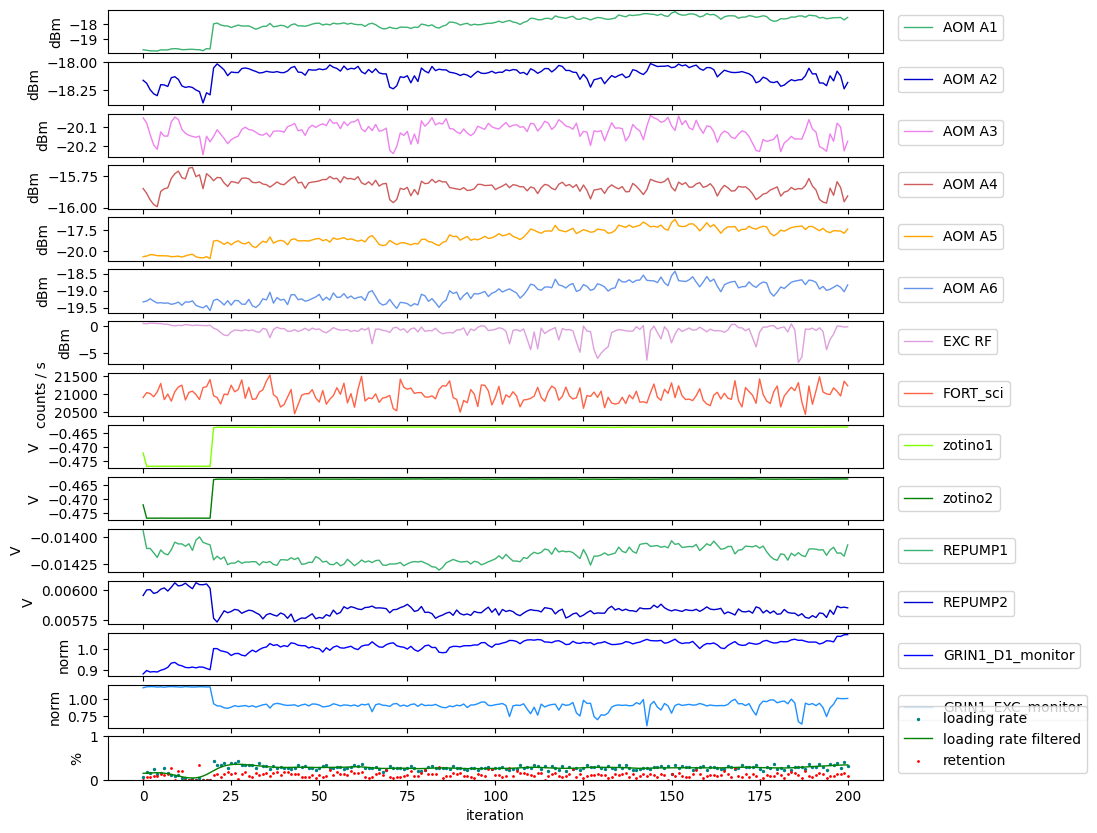

In [68]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""


i = 9 # At iteration ~20th: GVO with single photon exp started & Cycler resumed after GVO. 

f = h5py.File(fnames[i])
print(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()

print("experiment:",experiment_function)

cutoff1 = cutoff2 = 0.02*single_atom_counts_per_s



aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse', 'g', 'aquamarine', 'salmon', 'b','dodgerblue', 'crimson','darkgreen','orange','magenta','cyan','purple','royalblue','lime','cornflowerblue','pink']

plot_num = 0

iterations = int(len(photocounts)/n_measurements)
iterations, n_measurements


fig,axes = plt.subplots(nrows=15,sharex=True, figsize = (10,10))

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1
    
# GRIN1 EXC RF history
RF_history = locals()['p_excitation_history']
RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)
axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[plot_num], label='EXC RF', lw=1) # dBm
axes[plot_num].set_ylabel("dBm")

plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# # READOUT BACKGROUND: 2
# READOUT_1 = locals()['photocounts']
# READOUT_2 = locals()['photocounts2']
# READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
# READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
# axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
# axes[plot_num].set_ylabel("counts / s")
# plot_num += 1
# axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
# axes[plot_num].set_ylabel("counts / s")
# plot_num += 1


# Zotino output to shim coils

# Zotino : 1
zotino_sci_history = locals()['zotino_test1_monitor']
zotino_sci_mean_by_iteration = average_over_measurement(n_measurements, zotino_sci_history)
axes[plot_num].plot(zotino_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='zotino1', lw=1)
axes[plot_num].set_ylabel("V")
plot_num += 1
zotino_sci_history2 = locals()['zotino_test1_monitor']
zotino_sci_mean_by_iteration2 = average_over_measurement(n_measurements, zotino_sci_history2)
axes[plot_num].plot(zotino_sci_mean_by_iteration2[:], color=aom_colors[plot_num], label='zotino2', lw=1)
axes[plot_num].set_ylabel("V")
plot_num += 1


# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

# # PUMPING REPUMP: 2
# for i in range(2): # this time include the free space beams too
#     repump_power = locals()[f'PUMPING_REPUMP{i+1}_monitor']
#     repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

#     axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'PUMPING_REPUMP{i+1}', lw=1) # dBm
#     axes[plot_num].set_ylabel("V")
#     plot_num += 1

# GRIN: D1
FORT_sci_history = locals()['GRIN1_D1_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history/0.03)
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_D1_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1
# GRIN: EXC
FORT_sci_history = locals()['GRIN1_EXC_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/set_point_excitation
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_EXC_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1

# Atom loading and retention
filter_sigma = 3

mean1_by_iteration = [np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)]
mean2_by_iteration = [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)]
filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded
    
filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
axes[plot_num].scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
axes[plot_num].plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

axes[plot_num].scatter(range(iterations), retention_array, color='red', label='retention', s=1)
axes[plot_num].set_ylabel("%")
axes[plot_num].set_ylim(0,1)


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))


plt.show()

In [69]:
fnames = get_files_by_criteria(date_filters=["2025-01-04"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["General"], # only find files containing all these strings #ExperimentCycler
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 11 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\18\000021204-GeneralVariableScan.h5) scanned over set_point_excitation
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\18\000021205-GeneralVariableScan.h5) scanned over set_point_excitation
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\18\000021206-GeneralVariableScan.h5) scanned over set_point_excitation
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\18\000021210-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\19\000021211-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\19\000021212-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 8 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\19\000021213-GeneralVariableS

C:\Networking Experiment\artiq codes\artiq-master\results\2025-01-04\19\000021218-GeneralVariableOptimizer.h5
experiment: single_photon_experiment


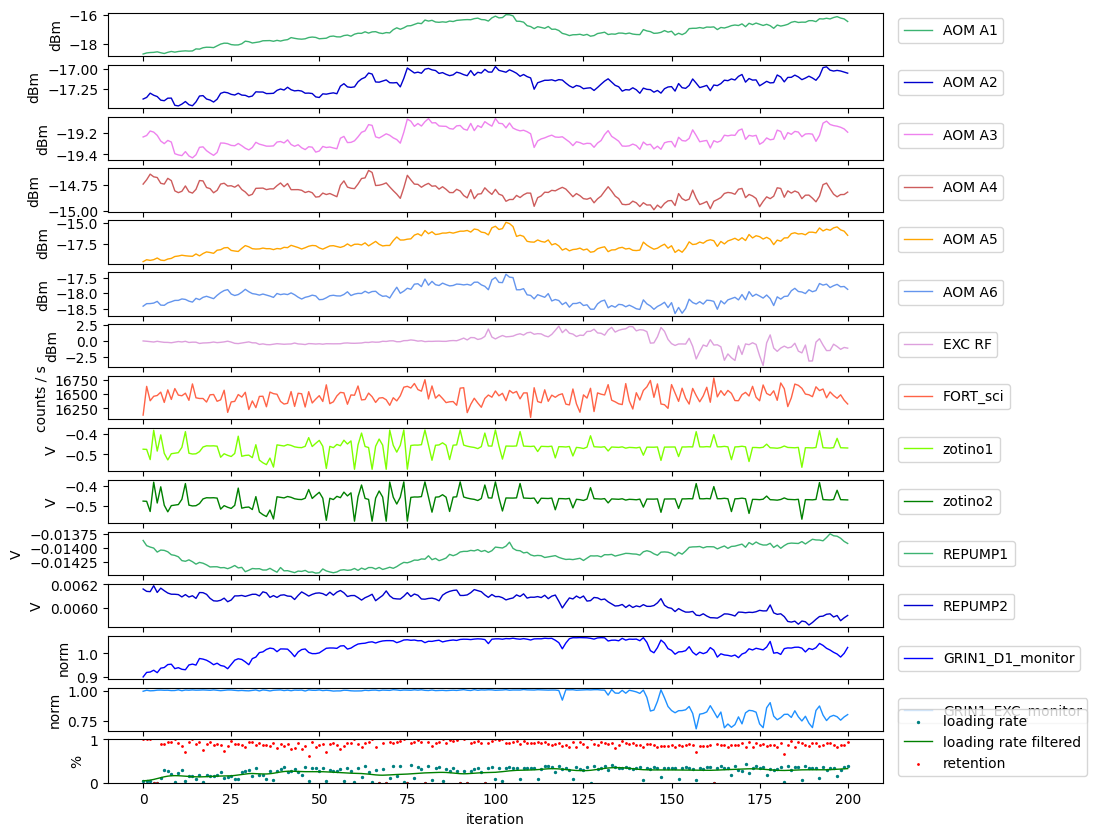

In [71]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""


i = 9 # General Variable Optimizer

f = h5py.File(fnames[i])
print(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()

print("experiment:",experiment_function)

cutoff1 = cutoff2 = 0.02*single_atom_counts_per_s



aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse', 'g', 'aquamarine', 'salmon', 'b','dodgerblue', 'crimson','darkgreen','orange','magenta','cyan','purple','royalblue','lime','cornflowerblue','pink']

plot_num = 0

iterations = int(len(photocounts)/n_measurements)
iterations, n_measurements


fig,axes = plt.subplots(nrows=15,sharex=True, figsize = (10,10))

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1
    
# GRIN1 EXC RF history
RF_history = locals()['p_excitation_history']
RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)
axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[plot_num], label='EXC RF', lw=1) # dBm
axes[plot_num].set_ylabel("dBm")

plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# # READOUT BACKGROUND: 2
# READOUT_1 = locals()['photocounts']
# READOUT_2 = locals()['photocounts2']
# READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
# READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
# axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
# axes[plot_num].set_ylabel("counts / s")
# plot_num += 1
# axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
# axes[plot_num].set_ylabel("counts / s")
# plot_num += 1


# Zotino output to shim coils

# Zotino : 1
zotino_sci_history = locals()['zotino_test1_monitor']
zotino_sci_mean_by_iteration = average_over_measurement(n_measurements, zotino_sci_history)
axes[plot_num].plot(zotino_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='zotino1', lw=1)
axes[plot_num].set_ylabel("V")
plot_num += 1
zotino_sci_history2 = locals()['zotino_test1_monitor']
zotino_sci_mean_by_iteration2 = average_over_measurement(n_measurements, zotino_sci_history2)
axes[plot_num].plot(zotino_sci_mean_by_iteration2[:], color=aom_colors[plot_num], label='zotino2', lw=1)
axes[plot_num].set_ylabel("V")
plot_num += 1


# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

# # PUMPING REPUMP: 2
# for i in range(2): # this time include the free space beams too
#     repump_power = locals()[f'PUMPING_REPUMP{i+1}_monitor']
#     repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

#     axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'PUMPING_REPUMP{i+1}', lw=1) # dBm
#     axes[plot_num].set_ylabel("V")
#     plot_num += 1

# GRIN: D1
FORT_sci_history = locals()['GRIN1_D1_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history/0.03)
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_D1_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1
# GRIN: EXC
FORT_sci_history = locals()['GRIN1_EXC_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/set_point_excitation
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_EXC_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1

# Atom loading and retention
filter_sigma = 3

mean1_by_iteration = [np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)]
mean2_by_iteration = [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)]
filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded
    
filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
axes[plot_num].scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
axes[plot_num].plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

axes[plot_num].scatter(range(iterations), retention_array, color='red', label='retention', s=1)
axes[plot_num].set_ylabel("%")
axes[plot_num].set_ylim(0,1)


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))


plt.show()

## 2024.12.30

In [56]:
fnames = get_files_by_criteria(date_filters=["2024-12-27", "2024-12-28","2024-12-30"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["Cycler"], # only find files containing all these strings #ExperimentCycler
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\16\000020963-ExperimentCycler.h5, which is corrupt
found 31 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\11\000020918-ExperimentCycler.h5)
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\11\000020921-ExperimentCycler.h5)
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\11\000020923-ExperimentCycler.h5)
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\11\000020924-ExperimentCycler.h5)
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\13\000020928-ExperimentCycler.h5)
file 8 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\13\000020929-ExperimentCycler.h5)
file 10 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\13\000020931-ExperimentCycler.h5)
file 12 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\

C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-30\12\000020969-ExperimentCycler.h5
experiment: microwave_Rabi_experiment


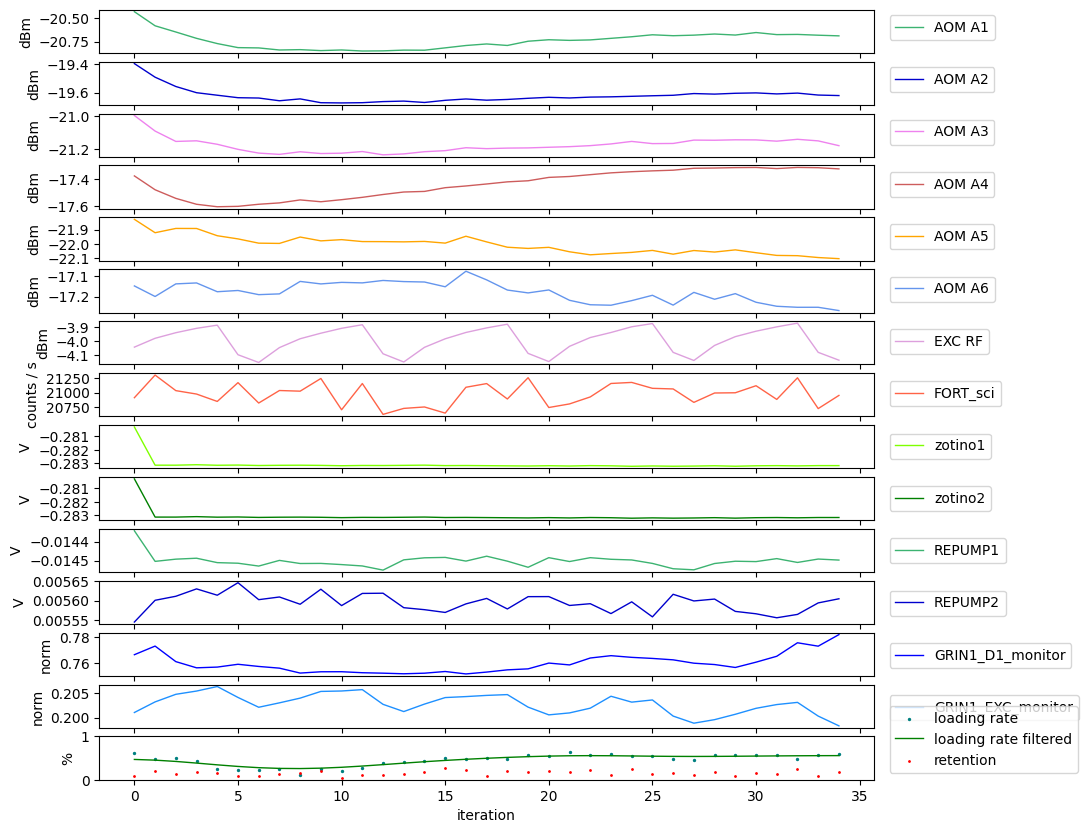

In [61]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

i = 27 #

f = h5py.File(fnames[i])
print(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()

print("experiment:",experiment_function)

cutoff1 = cutoff2 = 0.02*single_atom_counts_per_s



aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse', 'g', 'aquamarine', 'salmon', 'b','dodgerblue', 'crimson','darkgreen','orange','magenta','cyan','purple','royalblue','lime','cornflowerblue','pink']

plot_num = 0

iterations = int(len(photocounts)/n_measurements)
iterations, n_measurements


fig,axes = plt.subplots(nrows=15,sharex=True, figsize = (10,10))

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1
    
# GRIN1 EXC RF history
RF_history = locals()['p_excitation_history']
RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)
axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[plot_num], label='EXC RF', lw=1) # dBm
axes[plot_num].set_ylabel("dBm")

plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# # READOUT BACKGROUND: 2
# READOUT_1 = locals()['photocounts']
# READOUT_2 = locals()['photocounts2']
# READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
# READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
# axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
# axes[plot_num].set_ylabel("counts / s")
# plot_num += 1
# axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
# axes[plot_num].set_ylabel("counts / s")
# plot_num += 1


# Zotino output to shim coils

# Zotino : 1
zotino_sci_history = locals()['zotino_test1_monitor']
zotino_sci_mean_by_iteration = average_over_measurement(n_measurements, zotino_sci_history)
axes[plot_num].plot(zotino_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='zotino1', lw=1)
axes[plot_num].set_ylabel("V")
plot_num += 1
zotino_sci_history2 = locals()['zotino_test1_monitor']
zotino_sci_mean_by_iteration2 = average_over_measurement(n_measurements, zotino_sci_history2)
axes[plot_num].plot(zotino_sci_mean_by_iteration2[:], color=aom_colors[plot_num], label='zotino2', lw=1)
axes[plot_num].set_ylabel("V")
plot_num += 1


# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

# # PUMPING REPUMP: 2
# for i in range(2): # this time include the free space beams too
#     repump_power = locals()[f'PUMPING_REPUMP{i+1}_monitor']
#     repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

#     axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'PUMPING_REPUMP{i+1}', lw=1) # dBm
#     axes[plot_num].set_ylabel("V")
#     plot_num += 1

# GRIN: D1
FORT_sci_history = locals()['GRIN1_D1_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history/0.03)
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_D1_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1
# GRIN: EXC
FORT_sci_history = locals()['GRIN1_EXC_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/set_point_excitation
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_EXC_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1

# Atom loading and retention
filter_sigma = 3

mean1_by_iteration = [np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)]
mean2_by_iteration = [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)]
filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded
    
filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
axes[plot_num].scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
axes[plot_num].plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

axes[plot_num].scatter(range(iterations), retention_array, color='red', label='retention', s=1)
axes[plot_num].set_ylabel("%")
axes[plot_num].set_ylim(0,1)


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))


plt.show()

In [64]:
fnames = get_files_by_criteria(date_filters=["2024-12-27", "2024-12-28","2024-12-30"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["General"], # only find files containing all these strings #ExperimentCycler
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 2 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\17\000020968-GeneralVariableOptimizer.h5)
skipped 1 redundant files
0 scan_variables over 0 variable scans


C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-27\17\000020968-GeneralVariableOptimizer.h5
experiment: atom_loading_experiment


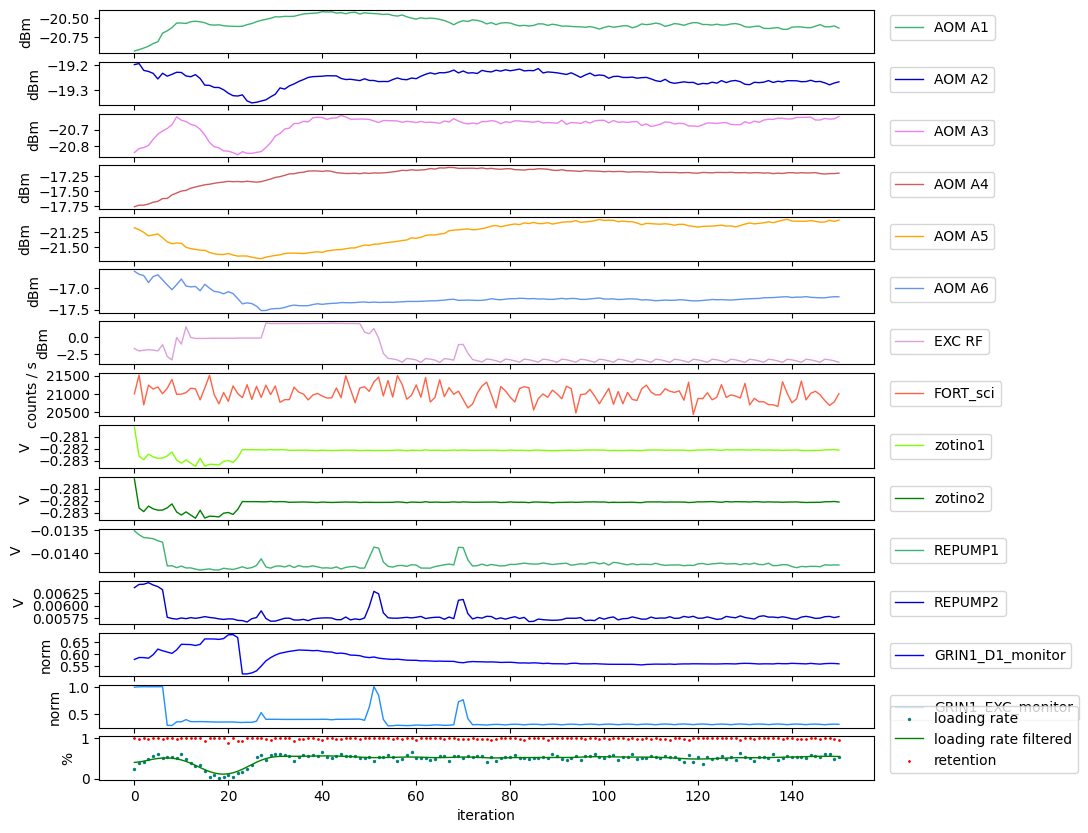

In [66]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

i = 0 #

f = h5py.File(fnames[i])
print(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()

print("experiment:",experiment_function)

cutoff1 = cutoff2 = 0.02*single_atom_counts_per_s



aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse', 'g', 'aquamarine', 'salmon', 'b','dodgerblue', 'crimson','darkgreen','orange','magenta','cyan','purple','royalblue','lime','cornflowerblue','pink']

plot_num = 0

iterations = int(len(photocounts)/n_measurements)
iterations, n_measurements


fig,axes = plt.subplots(nrows=15,sharex=True, figsize = (10,10))

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1
    
# GRIN1 EXC RF history
RF_history = locals()['p_excitation_history']
RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)
axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[plot_num], label='EXC RF', lw=1) # dBm
axes[plot_num].set_ylabel("dBm")

plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# # READOUT BACKGROUND: 2
# READOUT_1 = locals()['photocounts']
# READOUT_2 = locals()['photocounts2']
# READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
# READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
# axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
# axes[plot_num].set_ylabel("counts / s")
# plot_num += 1
# axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
# axes[plot_num].set_ylabel("counts / s")
# plot_num += 1


# Zotino output to shim coils

# Zotino : 1
zotino_sci_history = locals()['zotino_test1_monitor']
zotino_sci_mean_by_iteration = average_over_measurement(n_measurements, zotino_sci_history)
axes[plot_num].plot(zotino_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='zotino1', lw=1)
axes[plot_num].set_ylabel("V")
plot_num += 1
zotino_sci_history2 = locals()['zotino_test1_monitor']
zotino_sci_mean_by_iteration2 = average_over_measurement(n_measurements, zotino_sci_history2)
axes[plot_num].plot(zotino_sci_mean_by_iteration2[:], color=aom_colors[plot_num], label='zotino2', lw=1)
axes[plot_num].set_ylabel("V")
plot_num += 1


# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

# # PUMPING REPUMP: 2
# for i in range(2): # this time include the free space beams too
#     repump_power = locals()[f'PUMPING_REPUMP{i+1}_monitor']
#     repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

#     axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'PUMPING_REPUMP{i+1}', lw=1) # dBm
#     axes[plot_num].set_ylabel("V")
#     plot_num += 1

# GRIN: D1
FORT_sci_history = locals()['GRIN1_D1_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history/0.03)
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_D1_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1
# GRIN: EXC
FORT_sci_history = locals()['GRIN1_EXC_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/set_point_excitation
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_EXC_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1

# Atom loading and retention
filter_sigma = 3

mean1_by_iteration = [np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)]
mean2_by_iteration = [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)]
filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded
    
filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
axes[plot_num].scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
axes[plot_num].plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

axes[plot_num].scatter(range(iterations), retention_array, color='red', label='retention', s=1)
axes[plot_num].set_ylabel("%")


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))


plt.show()

## 2024.12.25

In [4]:
fnames = get_files_by_criteria(date_filters=["2024-12-25"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["General"], # only find files containing all these strings #ExperimentCycler
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-25\11\000020868-GeneralVariableScan_single_photon_experiment_atom_load_scan_over_set_point_excitation.h5, which is corrupt
found 2 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-25\10\000020867-GeneralVariableScan.h5) scanned over set_point_excitation
skipped 1 redundant files
1 scan_variables over 1 variable scans


experiment: single_photon_experiment_atom_loading_advance


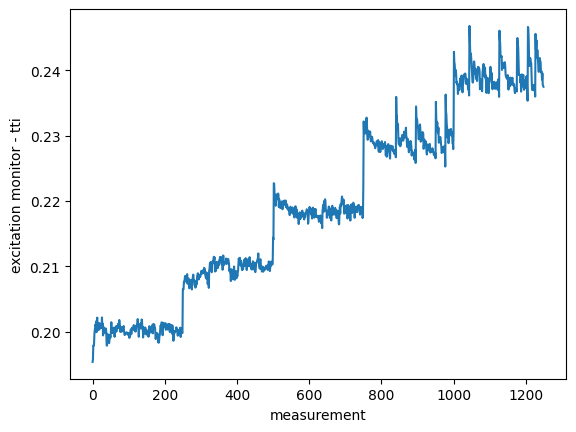

In [12]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

i = 0 #

f = h5py.File(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()

print("experiment:",experiment_function)

cutoff1 = cutoff2 = single_atom_counts_per_s



aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse', 'g', 'aquamarine', 'salmon', 'b','dodgerblue']

plot_num = 0

iterations = int(len(photocounts)/n_measurements)
iterations, n_measurements


plt.plot(GRIN1_EXC_monitor[1:])
plt.xlabel("measurement")
plt.ylabel("excitation monitor - tti")
plt.show()


# atom_loading_hist()

In [ ]:
fig,axes = plt.subplots(nrows=15,sharex=True)
# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1
    
# GRIN1 EXC RF history
RF_history = locals()['p_excitation_history']
RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)
axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[plot_num], label='EXC RF', lw=1) # dBm
axes[plot_num].set_ylabel("dBm")

plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

# GRIN: D1
FORT_sci_history = locals()['GRIN1_D1_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history/0.03)
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_D1_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1
# GRIN: EXC
FORT_sci_history = locals()['GRIN1_EXC_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/set_point_excitation
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_EXC_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1

# Atom loading and retention
filter_sigma = 3

mean1_by_iteration = [np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)]
mean2_by_iteration = [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)]
filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded
    
filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
axes[plot_num].scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
axes[plot_num].plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

axes[plot_num].scatter(range(iterations), retention_array, color='red', label='retention', s=1)
axes[plot_num].set_ylabel("%")


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()

## 2024.12.17

In [6]:
fnames = get_files_by_criteria(date_filters=["2024-12-17"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["General"], # only find files containing all these strings #ExperimentCycler
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-17\09\000020491-GeneralVariableScan.h5, which is corrupt
skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-17\17\000020507-GeneralVariableScan.h5, which is corrupt
skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-17\22\000020525-GeneralVariableScan.h5, which is corrupt
found 24 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-17\11\000020500-GeneralVariableScan.h5) scanned over set_point_excitation
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-17\11\000020501-GeneralVariableScan.h5) scanned over set_point_excitation
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-17\11\000020502-GeneralVariableScan.h5) scanned over set_point_excitation
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-17\11\000020503-GeneralVariableScan.h5) scanned over set_point_excitati

experiment: single_photon_experiment


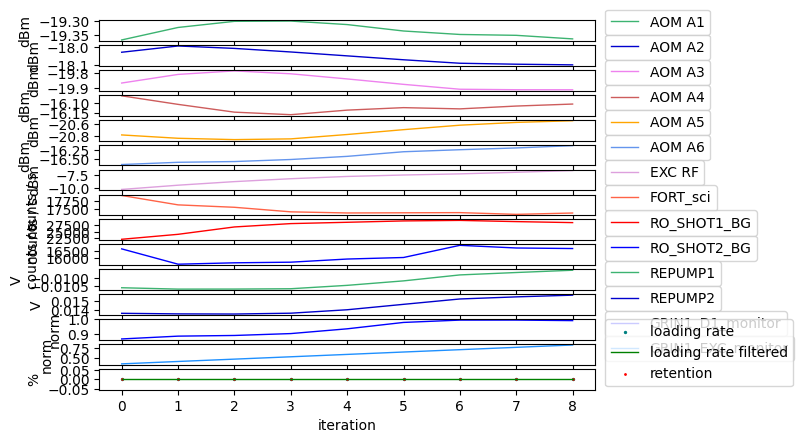

In [11]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

i = 23 #

f = h5py.File(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()

print("experiment:",experiment_function)

cutoff1 = cutoff2 = single_atom_counts_per_s

fig,axes = plt.subplots(nrows=15,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse', 'g', 'aquamarine', 'salmon', 'b','dodgerblue']

plot_num = 0

iterations = int(len(photocounts)/n_measurements)
iterations, n_measurements

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1
    
# GRIN1 EXC RF history
RF_history = locals()['p_excitation_history']
RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)
axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[plot_num], label='EXC RF', lw=1) # dBm
axes[plot_num].set_ylabel("dBm")

plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

# GRIN: D1
FORT_sci_history = locals()['GRIN1_D1_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history/0.03)
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_D1_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1
# GRIN: EXC
FORT_sci_history = locals()['GRIN1_EXC_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/set_point_excitation
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_EXC_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1

# Atom loading and retention
filter_sigma = 3

mean1_by_iteration = [np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)]
mean2_by_iteration = [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)]
filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded
    
filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
axes[plot_num].scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
axes[plot_num].plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

axes[plot_num].scatter(range(iterations), retention_array, color='red', label='retention', s=1)
axes[plot_num].set_ylabel("%")


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()


# atom_loading_hist()

## 2024.12.14

In [67]:
fnames = get_files_by_criteria(date_filters=["2024-12-13"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["ExperimentCycler"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 4 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-13\11\000020443-ExperimentCycler.h5)
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-13\17\000020444-ExperimentCycler.h5)
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-13\17\000020445-ExperimentCycler_microwave_Rabi.h5)
skipped 1 redundant files
0 scan_variables over 0 variable scans


experiment: microwave_Rabi_experiment


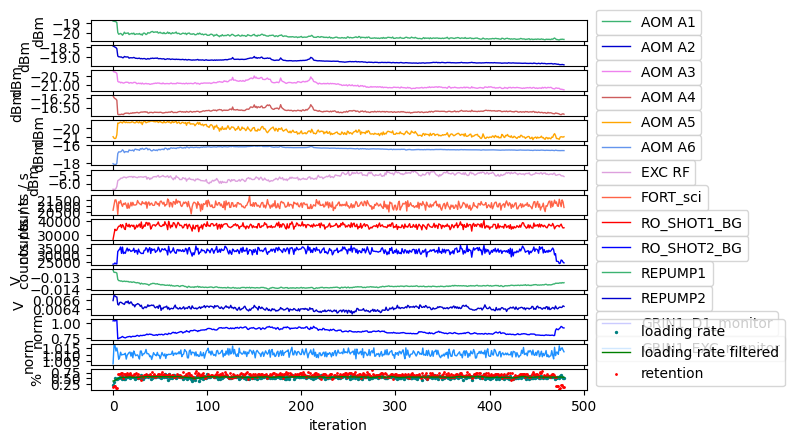

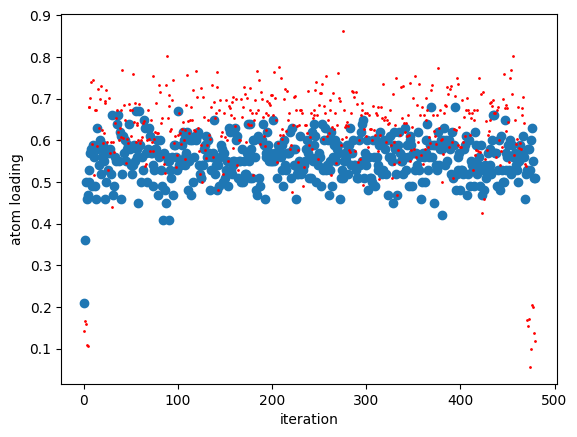

In [70]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

i = 3 #

f = h5py.File(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()

print("experiment:",experiment_function)


fig,axes = plt.subplots(nrows=15,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse', 'g', 'aquamarine', 'salmon', 'b','dodgerblue']

plot_num = 0

iterations = int(len(photocounts)/n_measurements)
iterations, n_measurements

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1
    
# GRIN1 EXC RF history
RF_history = locals()['p_excitation_history']
RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)
axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[plot_num], label='EXC RF', lw=1) # dBm
axes[plot_num].set_ylabel("dBm")

plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

# GRIN: D1
FORT_sci_history = locals()['GRIN1_D1_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history/0.03)
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_D1_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1
# GRIN: EXC
FORT_sci_history = locals()['GRIN1_EXC_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/set_point_excitation
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_EXC_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1

# Atom loading and retention
filter_sigma = 3

mean1_by_iteration = [np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)]
mean2_by_iteration = [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)]
filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded
    
filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
axes[plot_num].scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
axes[plot_num].plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

axes[plot_num].scatter(range(iterations), retention_array, color='red', label='retention', s=1)
axes[plot_num].set_ylabel("%")


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()


# atom_loading_hist()

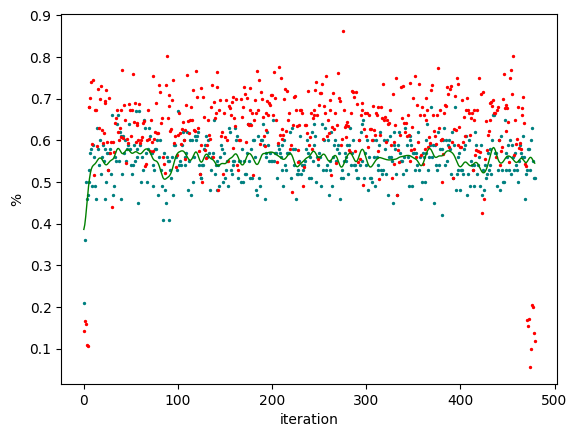

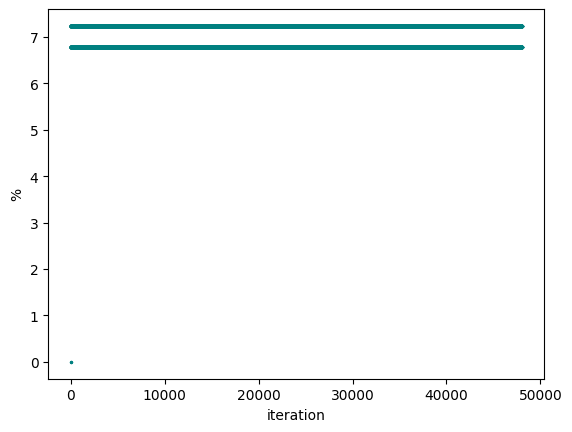

In [85]:
filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
plt.scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
plt.plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

plt.scatter(range(iterations), retention_array, color='red', label='retention', s=2)
plt.ylabel("%")
plt.xlabel('iteration')
plt.show()


plt.scatter(range(len(zotino_test1_monitor)), zotino_test1_monitor, color='teal',label='loading rate', s=2)
plt.scatter(range(len(zotino_test2_monitor)), zotino_test2_monitor, color='teal',label='loading rate', s=2)
# plt.plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

# plt.scatter(range(iterations), retention_array, color='red', label='retention', s=2)
plt.ylabel("%")
plt.xlabel('iteration')
plt.show()

## 2024.12.12

In [62]:
fnames = get_files_by_criteria(date_filters=["2024-12-12", "2024-12-13"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["ExperimentCycler"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 20 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-12\09\000020360-ExperimentCycler_microwave_Rabi.h5)
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-12\09\000020361-ExperimentCycler.h5)
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-12\10\000020369-ExperimentCycler.h5)
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-12\11\000020370-ExperimentCycler.h5)
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-12\11\000020371-ExperimentCycler.h5)
file 9 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-12\12\000020384-ExperimentCycler.h5)
file 11 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-12\12\000020386-ExperimentCycler.h5)
file 13 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-12\13\000020387-ExperimentCycler.h5)
file 15 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-12\13

experiment: microwave_Rabi_experiment


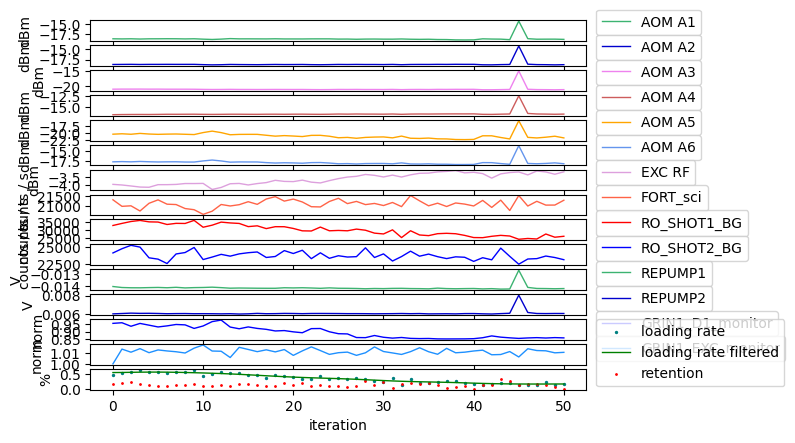

In [64]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

i = 19 #

f = h5py.File(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()

print("experiment:",experiment_function)


fig,axes = plt.subplots(nrows=15,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse', 'g', 'aquamarine', 'salmon', 'b','dodgerblue']

plot_num = 0

iterations = int(len(photocounts)/n_measurements)
iterations, n_measurements

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1
    
# GRIN1 EXC RF history
RF_history = locals()['p_excitation_history']
RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)
axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[plot_num], label='EXC RF', lw=1) # dBm
axes[plot_num].set_ylabel("dBm")

plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

# GRIN: D1
FORT_sci_history = locals()['GRIN1_D1_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history/0.03)
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_D1_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1
# GRIN: EXC
FORT_sci_history = locals()['GRIN1_EXC_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/set_point_excitation
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_EXC_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1

# Atom loading and retention
filter_sigma = 3

mean1_by_iteration = [np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)]
mean2_by_iteration = [np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)]
filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded
    
filtered_loading = gaussian_filter(loading_rate_array, sigma=filter_sigma)
axes[plot_num].scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
axes[plot_num].plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

axes[plot_num].scatter(range(iterations), retention_array, color='red', label='retention', s=1)
axes[plot_num].set_ylabel("%")


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()


# atom_loading_hist()



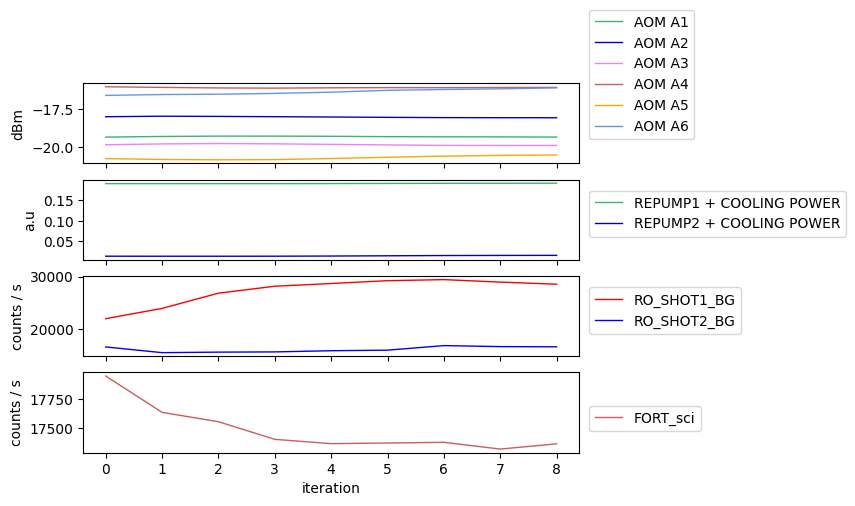

In [12]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration

fig,axes = plt.subplots(nrows=4,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse']

plot_num = 0

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("dBm")
    
plot_num += 1

# REPUMP + COOLING
offset = 0.2
zoom = 1

for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    if i == 0:
        repump_power_mean_by_iteration = (average_over_measurement(n_measurements, (repump_power + offset)*zoom) )
    elif i == 1:
        repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power*zoom)
    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1} + COOLING POWER', lw=1) # dBm
    axes[plot_num].set_ylabel("a.u")

plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration, color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()

## 2024.12.12

In [3]:
fnames = get_files_by_criteria(date_filters=["2024-12-11"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["ExperimentCycler"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 8 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-11\10\000020277-ExperimentCycler.h5)
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-11\10\000020283-ExperimentCycler.h5)
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-11\15\000020290-ExperimentCycler.h5)
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-11\17\000020359-ExperimentCycler.h5)
skipped 4 redundant files
0 scan_variables over 0 variable scans


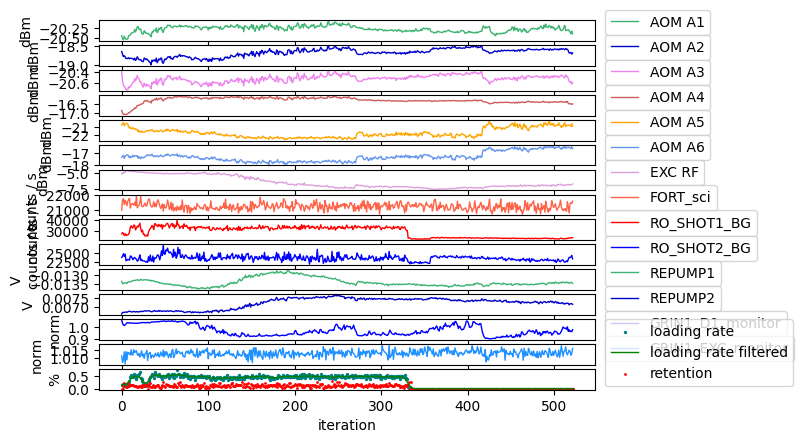

In [57]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

fig,axes = plt.subplots(nrows=15,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse', 'g', 'aquamarine', 'salmon', 'b','dodgerblue']

plot_num = 0

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1
    
# GRIN1 EXC RF history
RF_history = locals()['p_excitation_history']
RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)
axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[plot_num], label='EXC RF', lw=1) # dBm
axes[plot_num].set_ylabel("dBm")

plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

# GRIN: D1
FORT_sci_history = locals()['GRIN1_D1_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history/0.03)
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_D1_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1
# GRIN: EXC
FORT_sci_history = locals()['GRIN1_EXC_monitor']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/set_point_excitation
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='GRIN1_EXC_monitor', lw=1)
axes[plot_num].set_ylabel("norm")
plot_num += 1

atom_loading_and_retention()
axes[plot_num].scatter(range(iterations), loading_rate_array, color='teal',label='loading rate', s=2)
axes[plot_num].plot(range(iterations), filtered_loading, color='green',label='loading rate filtered', lw=1)

axes[plot_num].scatter(range(iterations), retention_array, color='red', label='retention', s=1)
axes[plot_num].set_ylabel("%")


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()


# atom_loading_hist()



## 2024.12.08 - atom loading drift

In [3]:
fnames = get_files_by_criteria(date_filters=["2024-12-07","2024-12-08"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["ExperimentCycler"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-08\00\000020173-ExperimentCycler.h5, which is corrupt
found 10 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-07\11\000020115-ExperimentCycler_microwave_Rabi.h5)
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-07\13\000020119-ExperimentCycler.h5)
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-07\13\000020125-ExperimentCycler_microwave_Rabi.h5)
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-07\16\000020127-ExperimentCycler.h5)
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-07\20\000020130-ExperimentCycler.h5)
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-07\21\000020159-ExperimentCycler.h5)
file 9 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-08\00\000020173-ExperimentCycler_microwave_Rabi.h5)
skipped 3 redundant files
0 scan_v

experiment: microwave_Rabi_experiment


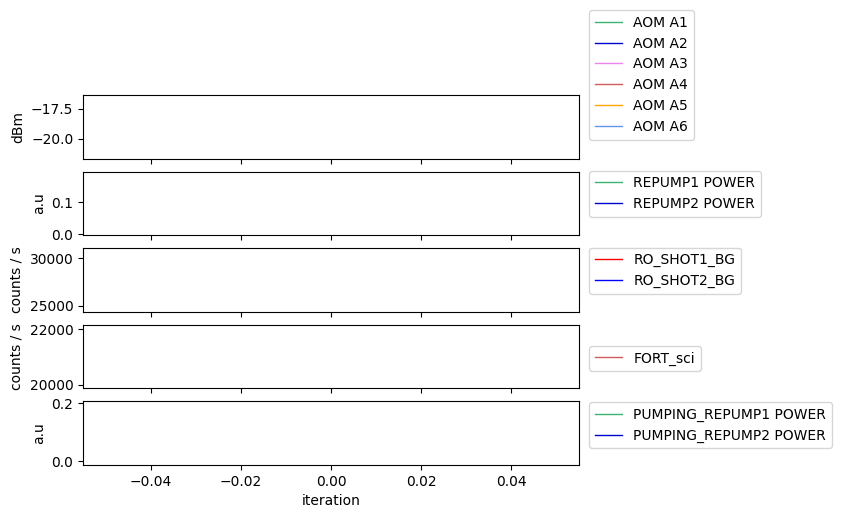

In [4]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

i = 7 #

f = h5py.File(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()

print("experiment:",experiment_function)

fig,axes = plt.subplots(nrows=5,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse']

plot_num = 0

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("dBm")
    
plot_num += 1

# REPUMP
offset = 0.2
zoom = 1

for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    if i == 0:
        repump_power_mean_by_iteration = (average_over_measurement(n_measurements, (repump_power + offset)*zoom) )
    elif i == 1:
        repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power*zoom)
    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1} POWER', lw=1) # dBm
    axes[plot_num].set_ylabel("a.u")

plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration, color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# PUMPING REPUMP
offset = 0.2
zoom = 1

for i in range(2): # this time include the free space beams too
    pumping_repump_power = locals()[f'PUMPING_REPUMP{i+1}_monitor']
    if i == 0:
        pumping_repump_power_mean_by_iteration = (average_over_measurement(n_measurements, (pumping_repump_power + offset)*zoom) )
    elif i == 1:
        pumping_repump_power_mean_by_iteration = average_over_measurement(n_measurements, pumping_repump_power*zoom)
    axes[plot_num].plot(pumping_repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'PUMPING_REPUMP{i+1} POWER', lw=1) # dBm
    axes[plot_num].set_ylabel("a.u")

plot_num += 1

axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()

## 2024.12.04

In [116]:
fnames = get_files_by_criteria(date_filters=["2024-12-04"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["ExperimentCycler"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 8 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-04\12\000019932-ExperimentCycler.h5)
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-04\12\000019937-ExperimentCycler.h5)
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-04\16\000019955-ExperimentCycler.h5)
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-04\17\000019956-ExperimentCycler.h5)
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-04\18\000019964-ExperimentCycler.h5)
file 7 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-12-04\18\000019966-ExperimentCycler_microwave_Rabi.h5)
skipped 2 redundant files
0 scan_variables over 0 variable scans


experiment: microwave_Rabi_experiment


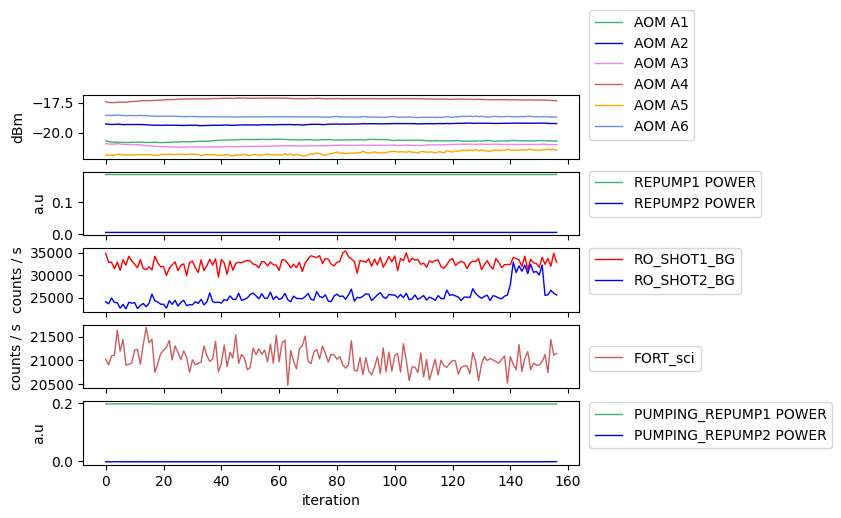

In [119]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

i = 7 #

f = h5py.File(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()
print("experiment:",experiment_function)

fig,axes = plt.subplots(nrows=5,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse']

plot_num = 0

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("dBm")
    
plot_num += 1

# REPUMP
offset = 0.2
zoom = 1

for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    if i == 0:
        repump_power_mean_by_iteration = (average_over_measurement(n_measurements, (repump_power + offset)*zoom) )
    elif i == 1:
        repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power*zoom)
    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1} POWER', lw=1) # dBm
    axes[plot_num].set_ylabel("a.u")

plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration, color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# PUMPING REPUMP
offset = 0.2
zoom = 1

for i in range(2): # this time include the free space beams too
    pumping_repump_power = locals()[f'PUMPING_REPUMP{i+1}_monitor']
    if i == 0:
        pumping_repump_power_mean_by_iteration = (average_over_measurement(n_measurements, (pumping_repump_power + offset)*zoom) )
    elif i == 1:
        pumping_repump_power_mean_by_iteration = average_over_measurement(n_measurements, pumping_repump_power*zoom)
    axes[plot_num].plot(pumping_repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'PUMPING_REPUMP{i+1} POWER', lw=1) # dBm
    axes[plot_num].set_ylabel("a.u")

plot_num += 1

axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()

## 2024.11.25 - optimizer -> cycler : jump in RF powers

In [110]:
fnames = get_files_by_criteria(date_filters=["2024-11-24"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["ExperimentCycler"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 14 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-24\17\000019554-ExperimentCycler.h5)
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-24\17\000019555-ExperimentCycler.h5)
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-24\17\000019556-ExperimentCycler.h5)
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-24\17\000019557-ExperimentCycler.h5)
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-24\17\000019558-ExperimentCycler.h5)
file 8 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-24\17\000019559-ExperimentCycler.h5)
file 10 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-24\18\000019560-ExperimentCycler.h5)
file 12 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-24\18\000019561-ExperimentCycler.h5)
skipped 6 redundant files
0 scan_variables over 0 variable scans


In [106]:
i = 12 #

f = h5py.File(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()
print("experiment:",experiment_function)

experiment: atom_loading_experiment


## AOM RF powers by iteration - individually

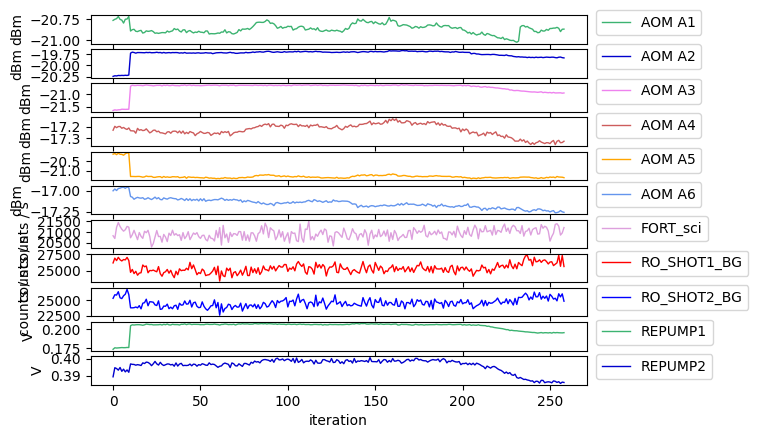

In [111]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

fig,axes = plt.subplots(nrows=11,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse']

plot_num = 0

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()



    

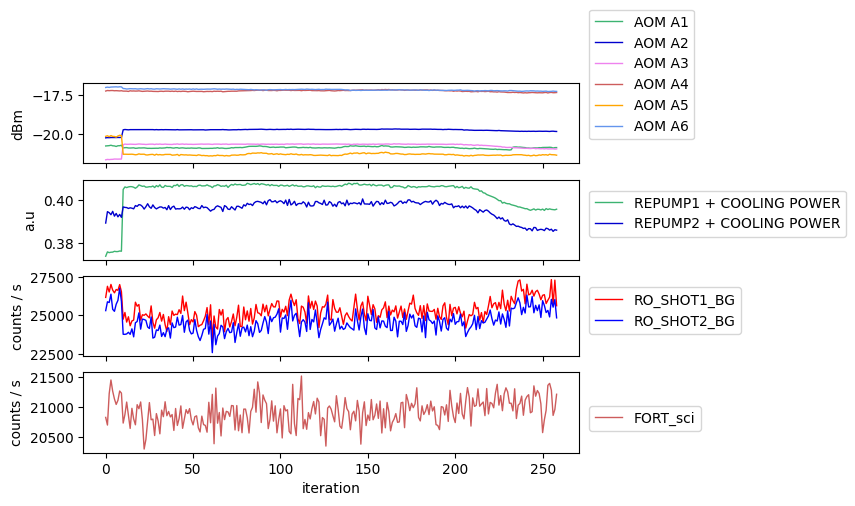

In [114]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration

fig,axes = plt.subplots(nrows=4,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse']

plot_num = 0

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("dBm")
    
plot_num += 1

# REPUMP + COOLING
offset = 0.2
zoom = 1

for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    if i == 0:
        repump_power_mean_by_iteration = (average_over_measurement(n_measurements, (repump_power + offset)*zoom) )
    elif i == 1:
        repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power*zoom)
    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1} + COOLING POWER', lw=1) # dBm
    axes[plot_num].set_ylabel("a.u")

plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration, color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()

## 2024.11.28

In [97]:
fnames = get_files_by_criteria(date_filters=["2024-11-27"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["ExperimentCycler"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f})")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 16 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-27\14\000019695-ExperimentCycler.h5)
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-27\14\000019698-ExperimentCycler.h5)
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-27\14\000019699-ExperimentCycler.h5)
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-27\15\000019702-ExperimentCycler.h5)
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-27\15\000019703-ExperimentCycler.h5)
file 8 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-27\16\000019707-ExperimentCycler.h5)
file 10 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-27\16\000019708-ExperimentCycler.h5)
file 12 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-27\17\000019710-ExperimentCycler.h5)
file 13 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-11-27\17\000019711-Expe

### comparison of Raman signal from FORT, readout background, AOM RF, loading/retention
the front of the experiment box is open with no temp feedback still (2024.08.16). the fans are on for air circulation and the sides of the box are closed.

what I want to show below: 
- MOT AOM RF correlates with the atom readout background minus the Raman from the FORT
- how much of the FORT Raman is attributable to shot noise

In [98]:
i = 15 #

f = h5py.File(fnames[i])
# rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
f.close()
print("experiment:",experiment_function)

experiment: atom_loading_experiment


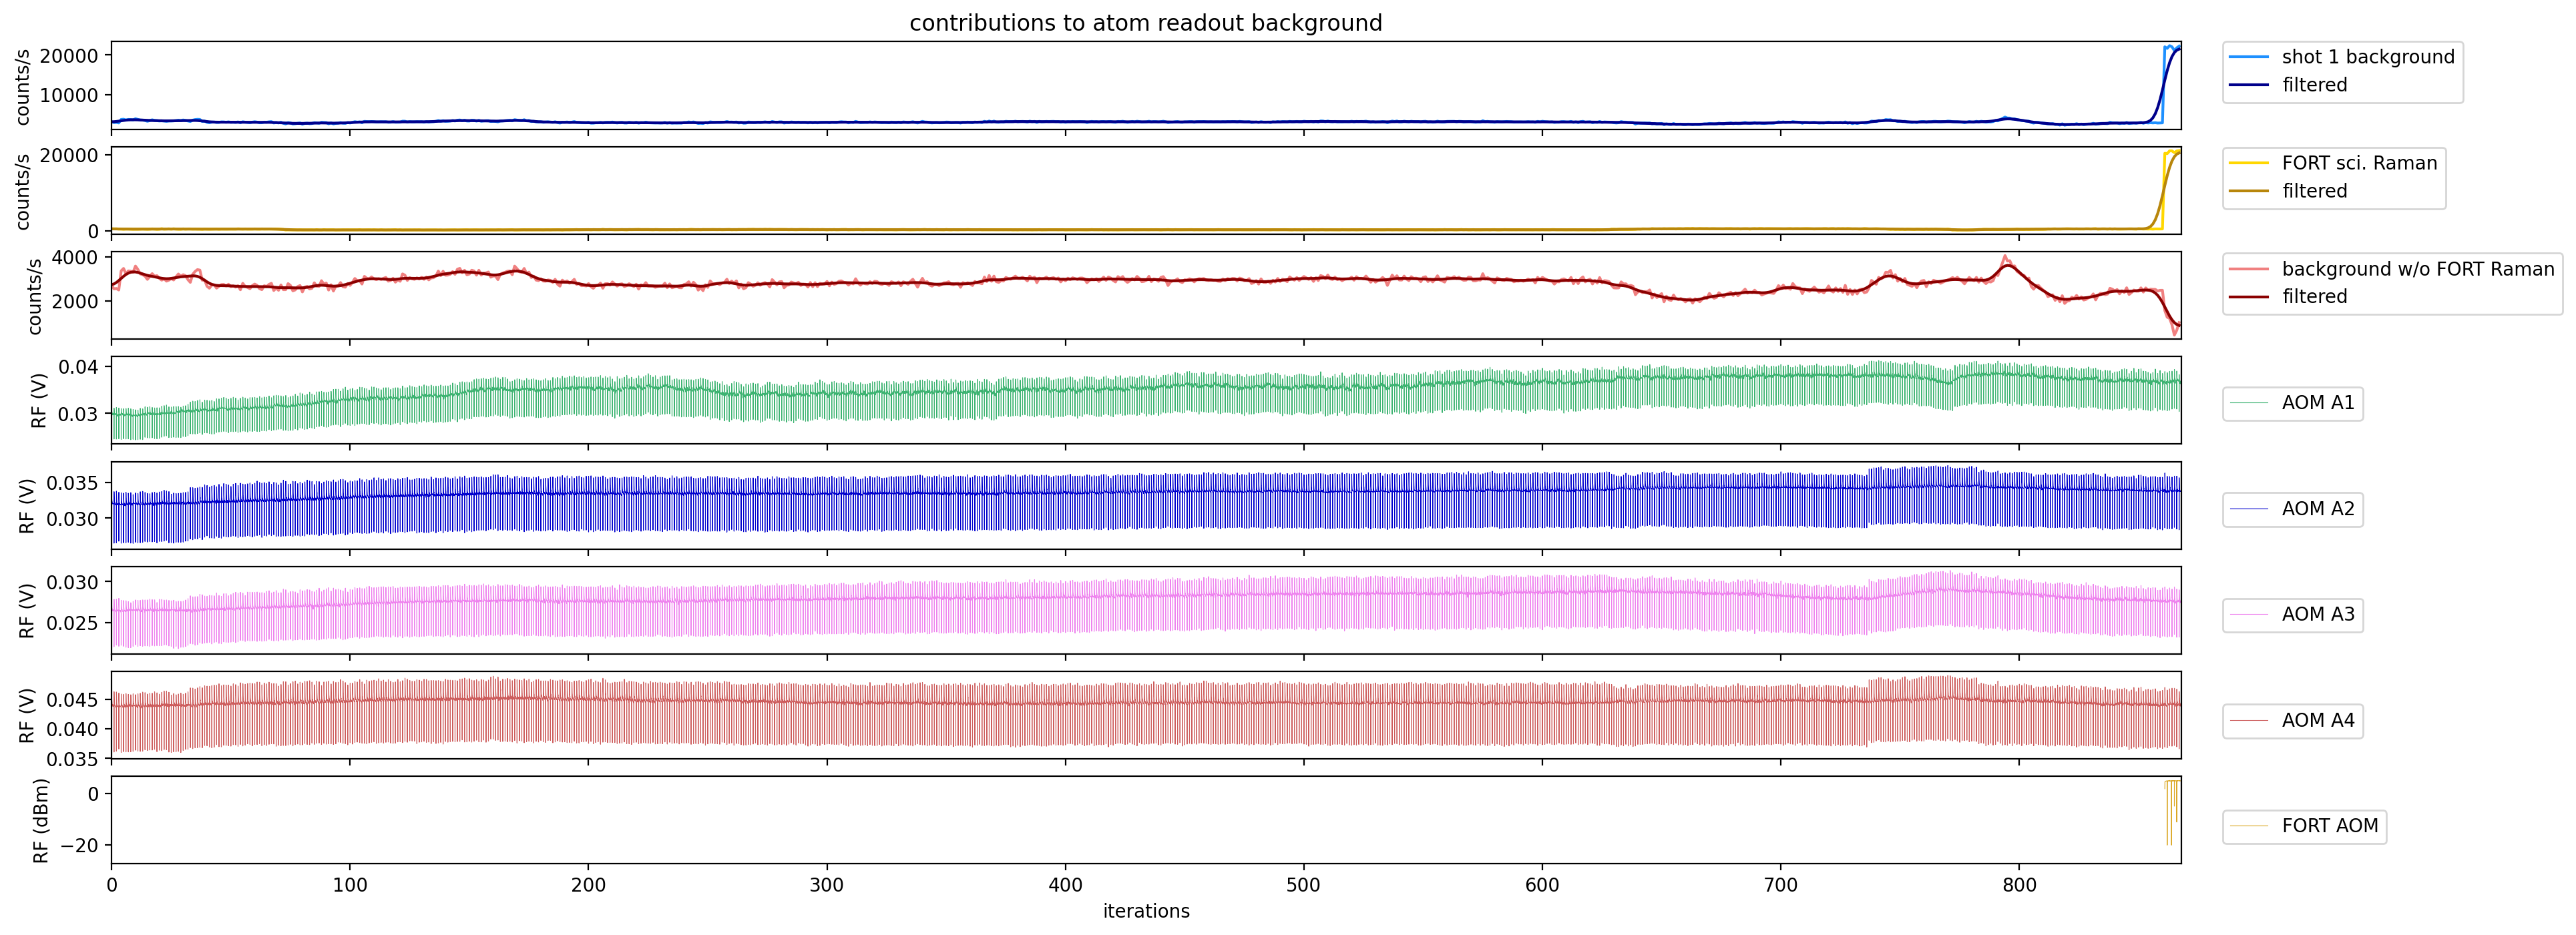

In [99]:
"""
plot mean background, FORT Raman, background - FORT Raman, MOT and FORT RF powers in separate subplots.

why does the FORT RF show such a drastically different noise profile to the fiber AOMs? it seems that perhaps the fiber AOMs have a really bad thermalization time which takes an entire iteration (i.e. 100 measurements here)
"""

filter_sigma = 3
cutoff1 = 550  # what does this do?

iterations = int(len(photocounts)/n_measurements)
iterations, n_measurements

mean1_by_iteration = np.array([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
filtered_mean_bg1 = gaussian_filter(mean1_by_iteration, sigma=filter_sigma)

fig,axes = plt.subplots(nrows=8,sharex=True,figsize=(20,8),dpi=200)
ax = axes[0]
ax2 = axes[1]
ax3 = axes[2]
ax4 = axes[3]
ax.plot(mean1_by_iteration,color='dodgerblue',label='shot 1 background')
ax.plot(filtered_mean_bg1, color='darkblue',label='filtered')
ax.set_ylabel("counts/s")

ax.set_title("contributions to atom readout background")

mean_FORT_sci_by_iteration = np.array([np.mean(photocounts_FORT_science[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot) 
                            for i in range(iterations)])
filtered_mean_FORT_sci = gaussian_filter(mean_FORT_sci_by_iteration, sigma=filter_sigma)

ax2.plot(mean_FORT_sci_by_iteration, color='gold', label='FORT sci. Raman')
ax2.plot(filtered_mean_FORT_sci, color='darkgoldenrod', label='filtered')
ax2.set_ylabel("counts/s")

mean_background_sans_FORT = mean1_by_iteration - mean_FORT_sci_by_iteration # can't do the subtraction at the measurement level because the readout background is taken only from measurements w/o atom loading
filtered_mean_background_sans_FORT = gaussian_filter(mean_background_sans_FORT, sigma=filter_sigma)

ax3.plot(mean_background_sans_FORT, color='lightcoral', label='background w/o FORT Raman')
ax3.plot(filtered_mean_background_sans_FORT, color='darkred', label='filtered')
ax3.set_ylabel("counts/s")

aom_colors = ['mediumseagreen','mediumblue','violet','indianred']

# RF powers in dBm
# for i in range(4):
#     RF_history = locals()[f'p_AOM_A{i+1}_history'][3:n_measurements*iterations]
#     # RF_history_filtered = gaussian_filter(RF_history, sigma=filter_sigma) # this doesn't really make sense to filter
#     ax4.plot(np.linspace(0,iterations,len(RF_history)), RF_history, color=aom_colors[i], label=f'AOM A{i+1}', lw=0.4)
# ax4.set_ylabel("RF (dBm)")

for i in range(4):
    RF_history = locals()[f'p_AOM_A{i+1}_history'] #[3:n_measurements*iterations]
    # axes[3+i].plot(np.linspace(0,iterations,len(RF_history)), RF_history, color=aom_colors[i], label=f'AOM A{i+1}', lw=0.4) # dBm
    axes[3+i].plot(np.linspace(0,iterations,len(RF_history)), (2 * 50 * 10 ** (RF_history / 10 - 3)) ** (1 / 2), color=aom_colors[i], label=f'AOM A{i+1}', lw=0.4) # volts
    axes[3+i].set_ylabel("RF (V)")

RF_history = locals()[f'p_FORT_loading_history'] #[3:n_measurements*iterations]
axes[-1].plot(np.linspace(0,iterations,len(RF_history)), RF_history, color='goldenrod', label=f'FORT AOM', lw=0.4) # dBm
# axes[2+i].plot(np.linspace(0,iterations,len(RF_history)), (2 * 50 * 10 ** (RF_history / 10 - 3)) ** (1 / 2), color=aom_colors[i], label=f'AOM A{i+1}', lw=0.4) # volts
axes[-1].set_ylabel("RF (dBm)")

axes[-1].set_xlabel("iterations")


retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))
    axis.set_xlim((0,iterations))

# plt.savefig(f'experiment_cycle_AOM_rf_500_iterationss_{rid}.png',bbox_inches='tight')
plt.show()

## AOM RF powers by iteration - individually

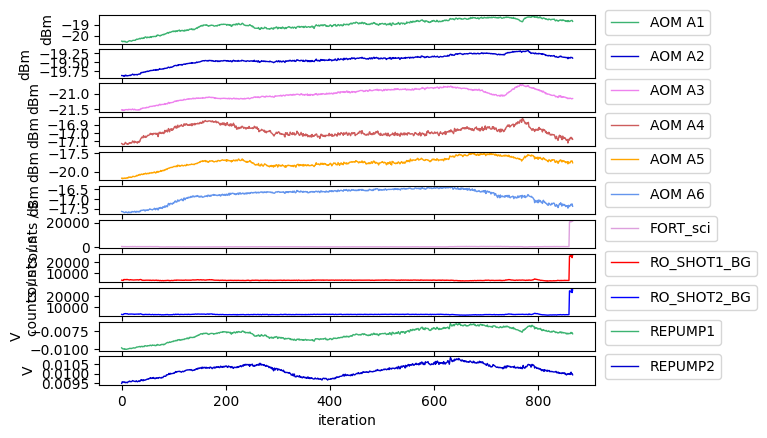

In [100]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration

fig,axes = plt.subplots(nrows=11,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse']

plot_num = 0

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[i].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[i].set_ylabel("dBm")

    plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration[:], color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# REPUMP: 2
for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power)

    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("V")
    plot_num += 1

axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()



    

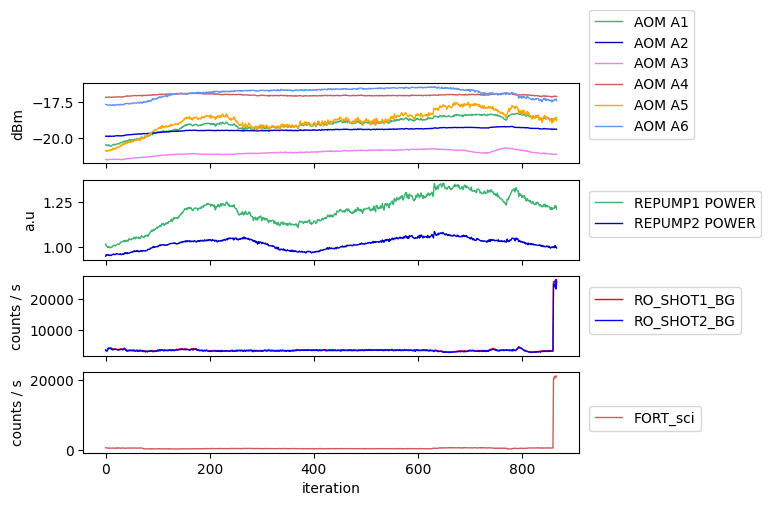

In [101]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration

fig,axes = plt.subplots(nrows=4,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse']

plot_num = 0

# AOM_RF_POWER: 6
for i in range(6): # this time include the free space beams too
    RF_history = locals()[f'p_AOM_A{i+1}_history']
    RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

    axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
    axes[plot_num].set_ylabel("dBm")
    
plot_num += 1

# REPUMP: 2
offset = 0.02
zoom = 100

for i in range(2): # this time include the free space beams too
    repump_power = locals()[f'REPUMP{i+1}_monitor']
    if i == 0:
        repump_power_mean_by_iteration = (average_over_measurement(n_measurements, (repump_power + offset)*zoom) )
    elif i == 1:
        repump_power_mean_by_iteration = average_over_measurement(n_measurements, repump_power*zoom)
    axes[plot_num].plot(repump_power_mean_by_iteration[:], color=aom_colors[i], label=f'REPUMP{i+1} POWER', lw=1) # dBm
    axes[plot_num].set_ylabel("a.u")

plot_num += 1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

# FORT : 1
FORT_sci_history = locals()['photocounts_FORT_science']
FORT_sci_mean_by_iteration = average_over_measurement(n_measurements, FORT_sci_history)/t_SPCM_first_shot
axes[plot_num].plot(FORT_sci_mean_by_iteration, color=aom_colors[plot_num], label='FORT_sci', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1

axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))

plt.show()

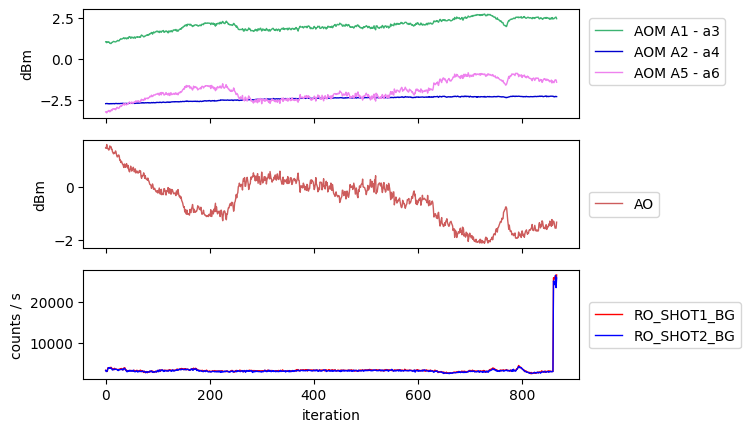

In [102]:
"""AOM RF powers by iteration - averaged over measurements in each iteration"""

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration

fig,axes = plt.subplots(nrows=3,sharex=True)

aom_colors = ['mediumseagreen','mediumblue','violet','indianred','orange','cornflowerblue', 'plum', 'tomato', 'chartreuse']

plot_num = 0

# # AOM_RF_POWER: 6
# for i in range(6): # this time include the free space beams too
#     RF_history = locals()[f'p_AOM_A{i+1}_history']
#     RF_mean_by_iteration = average_over_measurement(n_measurements, RF_history)

#     axes[plot_num].plot(RF_mean_by_iteration[:], color=aom_colors[i], label=f'AOM A{i+1}', lw=1) # dBm
#     axes[plot_num].set_ylabel("dBm")

# mean_by_iteration
RF1 = average_over_measurement(n_measurements, locals()['p_AOM_A1_history'])
RF2 = average_over_measurement(n_measurements, locals()['p_AOM_A2_history'])
RF3 = average_over_measurement(n_measurements, locals()['p_AOM_A3_history'])
RF4 = average_over_measurement(n_measurements, locals()['p_AOM_A4_history'])
RF5 = average_over_measurement(n_measurements, locals()['p_AOM_A5_history'])
RF6 = average_over_measurement(n_measurements, locals()['p_AOM_A6_history'])

beam1 = [x - y for x, y in zip(RF1, RF3)]
beam2 = [x - y for x, y in zip(RF2, RF4)]
beam3 = [x - y for x, y in zip(RF5, RF6)]

axes[plot_num].plot(beam1, color=aom_colors[0], label=f'AOM A1 - a3', lw=1)
axes[plot_num].plot(beam2, color=aom_colors[1], label=f'AOM A2 - a4', lw=1)
axes[plot_num].plot(beam3, color=aom_colors[2], label=f'AOM A5 - a6', lw=1)
axes[plot_num].set_ylabel("dBm")
plot_num +=1


# Variable
beam123 = [-1*x + 1*(y+2) - z for x, y, z in zip(beam1, beam2, beam3)]

axes[plot_num].plot(beam123, color=aom_colors[3], label=f'AO', lw=1)
axes[plot_num].set_ylabel("dBm")
plot_num +=1

# READOUT BACKGROUND: 2
READOUT_1 = locals()['photocounts']
READOUT_2 = locals()['photocounts2']
READOUT_1_mean_by_iteration = average_over_measurement(n_measurements, READOUT_1)/t_SPCM_first_shot
READOUT_2_mean_by_iteration = average_over_measurement(n_measurements, READOUT_2)/t_SPCM_first_shot
axes[plot_num].plot(READOUT_1_mean_by_iteration[:], color='red', label='RO_SHOT1_BG', lw=1)
axes[plot_num].plot(READOUT_2_mean_by_iteration[:], color='blue', label='RO_SHOT2_BG', lw=1)
axes[plot_num].set_ylabel("counts / s")
plot_num += 1


axes[-1].set_xlabel("iteration")

for i,axis in enumerate(axes):
    axis.legend(loc=(1.02, 0.3-i*0.01))
